In [1]:
import collections
from sklearn.metrics import precision_recall_fscore_support
import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm

In [2]:
seed = 9027

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [3]:
train_data, test_data = datasets.load_dataset("imdb", split=["train", "test"])

In [4]:
train_data, test_data

(Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }))

In [5]:
train_data.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

In [6]:
train_data[0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [7]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

In [8]:
tokenizer("Hello world! How are you doing today? I'm doing fantastic!")

['hello',
 'world',
 '!',
 'how',
 'are',
 'you',
 'doing',
 'today',
 '?',
 'i',
 "'",
 'm',
 'doing',
 'fantastic',
 '!']

In [9]:
def tokenize_example(example, tokenizer, max_length):
    tokens = tokenizer(example["text"])[:max_length]
    return {"tokens": tokens}

In [10]:
max_length = 256

train_data = train_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)
test_data = test_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)

In [11]:
train_data

Dataset({
    features: ['text', 'label', 'tokens'],
    num_rows: 25000
})

In [12]:
train_data.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [13]:
train_data[0]["tokens"][:25]

['i',
 'rented',
 'i',
 'am',
 'curious-yellow',
 'from',
 'my',
 'video',
 'store',
 'because',
 'of',
 'all',
 'the',
 'controversy',
 'that',
 'surrounded',
 'it',
 'when',
 'it',
 'was',
 'first',
 'released',
 'in',
 '1967',
 '.']

In [14]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

In [15]:
len(train_data), len(valid_data), len(test_data)

(18750, 6250, 25000)

In [16]:
min_freq = 5
special_tokens = ["<unk>", "<pad>"]

vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

In [17]:
len(vocab)

21574

In [18]:
vocab.get_itos()[:10]

['<unk>', '<pad>', 'the', '.', ',', 'a', 'and', 'of', 'to', "'"]

In [19]:
vocab["and"]

6

In [20]:
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]

In [21]:
"some_token" in vocab

False

In [22]:
vocab.set_default_index(unk_index)

In [23]:
vocab["some_token"]

0

In [24]:
vocab.lookup_indices(["hello", "world", "some_token", "<pad>"])

[4471, 188, 0, 1]

In [25]:
def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["tokens"])
    return {"ids": ids}

In [26]:
train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

Map:   0%|          | 0/18750 [00:00<?, ? examples/s]

Map:   0%|          | 0/6250 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [27]:
train_data[0]["tokens"][:10]

['i',
 'saw',
 'this',
 'movie',
 'recently',
 'because',
 'a',
 'friend',
 'brought',
 'it']

In [28]:
vocab.lookup_indices(train_data[0]["tokens"][:10])

[12, 187, 14, 18, 862, 90, 5, 438, 819, 11]

In [29]:
train_data[0]["ids"][:10]

[12, 187, 14, 18, 862, 90, 5, 438, 819, 11]

In [30]:
train_data = train_data.with_format(type="torch", columns=["ids", "label"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label"])
test_data = test_data.with_format(type="torch", columns=["ids", "label"])

In [31]:
train_data[0]["label"]

tensor(0)

In [32]:
train_data[0]["ids"][:10]

tensor([ 12, 187,  14,  18, 862,  90,   5, 438, 819,  11])

In [33]:
train_data[0].keys()

dict_keys(['label', 'ids'])

In [34]:
vocab.lookup_tokens(train_data[0]["ids"][:10].tolist())

['i',
 'saw',
 'this',
 'movie',
 'recently',
 'because',
 'a',
 'friend',
 'brought',
 'it']

In [35]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "label": batch_label}
        return batch

    return collate_fn

In [36]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [37]:
batch_size = 512

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [38]:
class NBoW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, ids):
        # ids = [batch size, seq len]
        embedded = self.embedding(ids)
        # embedded = [batch size, seq len, embedding dim]
        pooled = embedded.mean(dim=1)
        # pooled = [batch size, embedding dim]
        prediction = self.fc(pooled)
        # prediction = [batch size, output dim]
        return prediction

In [39]:
vocab_size = len(vocab)
embedding_dim = 300
output_dim = len(train_data.unique("label"))

model = NBoW(vocab_size, embedding_dim, output_dim, pad_index)

In [40]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 6,472,802 trainable parameters


In [41]:
vectors = torchtext.vocab.GloVe()

In [42]:
hello_vector = vectors.get_vecs_by_tokens("hello")

In [43]:
hello_vector.shape

torch.Size([300])

In [44]:
hello_vector[:32]

tensor([ 0.2523,  0.1018, -0.6748,  0.2112,  0.4349,  0.1654,  0.4826, -0.8122,
         0.0413,  0.7850, -0.0779, -0.6632,  0.1464, -0.2929, -0.2549,  0.0193,
        -0.2026,  0.9823,  0.0283, -0.0813, -0.1214,  0.1313, -0.1765,  0.1356,
        -0.1636, -0.2257,  0.0550, -0.2031,  0.2072,  0.0958,  0.2248,  0.2154])

In [45]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

In [46]:
pretrained_embedding.shape

torch.Size([21574, 300])

In [47]:
model.embedding.weight

Parameter containing:
tensor([[ 0.0934, -0.5176, -0.5314,  ...,  0.3771, -1.2457,  1.0908],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.7530,  0.2243,  0.4843,  ..., -0.6605, -1.1781, -0.3280],
        ...,
        [ 1.5667, -0.1287, -0.7330,  ..., -0.4835,  0.0091,  0.6470],
        [ 1.3670,  0.6465, -0.6097,  ..., -0.7860, -0.2024, -0.2394],
        [ 0.6556, -0.1013,  0.3019,  ..., -0.8049,  1.7237,  0.0329]],
       requires_grad=True)

In [48]:
pretrained_embedding

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2720, -0.0620, -0.1884,  ...,  0.1302, -0.1832,  0.1323],
        ...,
        [ 0.5050,  0.0609,  0.3423,  ...,  0.0625, -0.1585,  0.1404],
        [ 0.4690, -0.0886,  0.0185,  ...,  0.5162, -0.1560,  0.7900],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [49]:
model.embedding.weight.data = pretrained_embedding

In [50]:
model.embedding.weight

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2720, -0.0620, -0.1884,  ...,  0.1302, -0.1832,  0.1323],
        ...,
        [ 0.5050,  0.0609,  0.3423,  ...,  0.0625, -0.1585,  0.1404],
        [ 0.4690, -0.0886,  0.0185,  ...,  0.5162, -0.1560,  0.7900],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       requires_grad=True)

In [51]:
optimizer = optim.Adam(model.parameters())

In [52]:
criterion = nn.CrossEntropyLoss()

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [54]:
model = model.to(device)
criterion = criterion.to(device)

In [55]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    epoch_precisions = []
    epoch_recalls = []
    epoch_f1s = []

    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        
        # Calculate accuracy
        accuracy = get_accuracy(prediction, label)
        
        # Calculate precision, recall, and F1 score
        preds = prediction.argmax(dim=1).detach().cpu().numpy()  # Get the max logit as the predicted class and move to CPU
        true = label.detach().cpu().numpy()  # Move true labels to CPU
        precision, recall, f1, _ = precision_recall_fscore_support(true, preds, average='macro')
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Append metrics
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy)
        epoch_precisions.append(precision)
        epoch_recalls.append(recall)
        epoch_f1s.append(f1)

    # Return the average of all epoch metrics
    return {
        'loss': np.mean(epoch_losses),
        'accuracy': np.mean(epoch_accs),
        'precision': np.mean(epoch_precisions),
        'recall': np.mean(epoch_recalls),
        'f1': np.mean(epoch_f1s)
    }

In [56]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    epoch_precisions = []
    epoch_recalls = []
    epoch_f1s = []

    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)

            # Convert predictions and labels to numpy arrays
            preds = prediction.argmax(dim=1).detach().cpu().numpy()
            true = label.detach().cpu().numpy()

            # Calculate precision, recall, and F1 score
            precision, recall, f1, _ = precision_recall_fscore_support(true, preds, average='macro')

            # Append metrics
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy)
            epoch_precisions.append(precision)
            epoch_recalls.append(recall)
            epoch_f1s.append(f1)

    # Return the average of all epoch metrics
    return {
        'loss': np.mean(epoch_losses),
        'accuracy': np.mean(epoch_accs),
        'precision': np.mean(epoch_precisions),
        'recall': np.mean(epoch_recalls),
        'f1': np.mean(epoch_f1s)
    }

In [57]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [58]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    # The train function now returns a dictionary with multiple metrics
    train_metrics = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_metrics = evaluate(
        valid_data_loader, model, criterion, device
    )
    
    # Save all the metrics
    for key, value in train_metrics.items():
        metrics[f"train_{key}"].append(value)
    for key, value in valid_metrics.items():
        metrics[f"valid_{key}"].append(value)
    
    # Check if the validation loss is the best one we've seen so far
    valid_loss = valid_metrics['loss']
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "nbow.pt")
    
    # Print out the metrics for this epoch
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_metrics['loss']:.3f}, train_acc: {train_metrics['accuracy']:.3f}, "
          f"train_precision: {train_metrics['precision']:.3f}, train_recall: {train_metrics['recall']:.3f}, "
          f"train_f1: {train_metrics['f1']:.3f}")
    print(f"valid_loss: {valid_metrics['loss']:.3f}, valid_acc: {valid_metrics['accuracy']:.3f}, "
          f"valid_precision: {valid_metrics['precision']:.3f}, valid_recall: {valid_metrics['recall']:.3f}, "
          f"valid_f1: {valid_metrics['f1']:.3f}")

evaluating...: 100%|██████████| 13/13 [00:01<00:00, 11.64it/s]


epoch: 0
train_loss: 0.683, train_acc: 0.571, train_precision: 0.642, train_recall: 0.570, train_f1: 0.496
valid_loss: 0.667, valid_acc: 0.674, valid_precision: 0.684, valid_recall: 0.674, valid_f1: 0.669


evaluating...: 100%|██████████| 13/13 [00:01<00:00, 11.87it/s]


epoch: 1
train_loss: 0.644, train_acc: 0.718, train_precision: 0.726, train_recall: 0.718, train_f1: 0.715
valid_loss: 0.620, valid_acc: 0.732, valid_precision: 0.737, valid_recall: 0.732, valid_f1: 0.730


evaluating...: 100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


epoch: 2
train_loss: 0.583, train_acc: 0.767, train_precision: 0.769, train_recall: 0.768, train_f1: 0.767
valid_loss: 0.555, valid_acc: 0.776, valid_precision: 0.776, valid_recall: 0.776, valid_f1: 0.776


evaluating...: 100%|██████████| 13/13 [00:01<00:00, 11.52it/s]


epoch: 3
train_loss: 0.510, train_acc: 0.813, train_precision: 0.815, train_recall: 0.813, train_f1: 0.813
valid_loss: 0.488, valid_acc: 0.818, valid_precision: 0.818, valid_recall: 0.818, valid_f1: 0.817


evaluating...: 100%|██████████| 13/13 [00:01<00:00, 10.94it/s]


epoch: 4
train_loss: 0.440, train_acc: 0.848, train_precision: 0.848, train_recall: 0.848, train_f1: 0.848
valid_loss: 0.433, valid_acc: 0.842, valid_precision: 0.842, valid_recall: 0.841, valid_f1: 0.841


evaluating...: 100%|██████████| 13/13 [00:01<00:00, 11.56it/s]


epoch: 5
train_loss: 0.384, train_acc: 0.872, train_precision: 0.872, train_recall: 0.872, train_f1: 0.872
valid_loss: 0.393, valid_acc: 0.853, valid_precision: 0.853, valid_recall: 0.853, valid_f1: 0.853


evaluating...: 100%|██████████| 13/13 [00:01<00:00, 11.60it/s]


epoch: 6
train_loss: 0.341, train_acc: 0.887, train_precision: 0.887, train_recall: 0.887, train_f1: 0.887
valid_loss: 0.365, valid_acc: 0.861, valid_precision: 0.861, valid_recall: 0.860, valid_f1: 0.860


evaluating...: 100%|██████████| 13/13 [00:01<00:00, 11.93it/s]


epoch: 7
train_loss: 0.308, train_acc: 0.899, train_precision: 0.899, train_recall: 0.899, train_f1: 0.899
valid_loss: 0.345, valid_acc: 0.866, valid_precision: 0.867, valid_recall: 0.866, valid_f1: 0.866


evaluating...: 100%|██████████| 13/13 [00:01<00:00, 11.58it/s]


epoch: 8
train_loss: 0.281, train_acc: 0.908, train_precision: 0.909, train_recall: 0.908, train_f1: 0.908
valid_loss: 0.330, valid_acc: 0.871, valid_precision: 0.871, valid_recall: 0.871, valid_f1: 0.871


evaluating...: 100%|██████████| 13/13 [00:01<00:00, 11.67it/s]

epoch: 9
train_loss: 0.258, train_acc: 0.917, train_precision: 0.917, train_recall: 0.917, train_f1: 0.917
valid_loss: 0.318, valid_acc: 0.874, valid_precision: 0.874, valid_recall: 0.874, valid_f1: 0.874


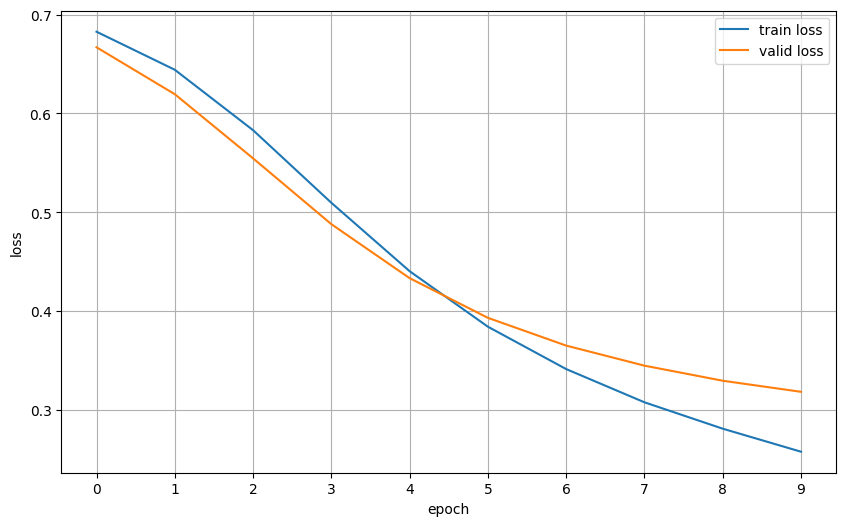

In [61]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics['train_loss'], label="train loss")
ax.plot(metrics['valid_loss'], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

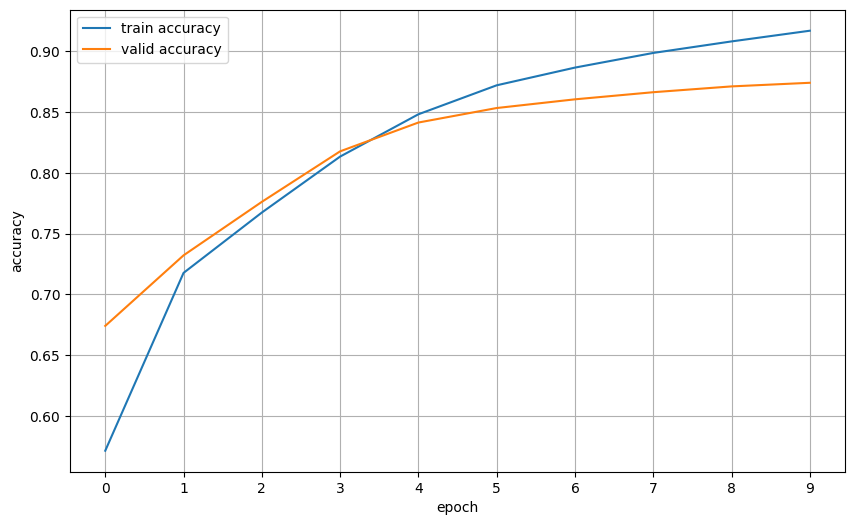

In [62]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics['train_accuracy'], label="train accuracy")
ax.plot(metrics['valid_accuracy'], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

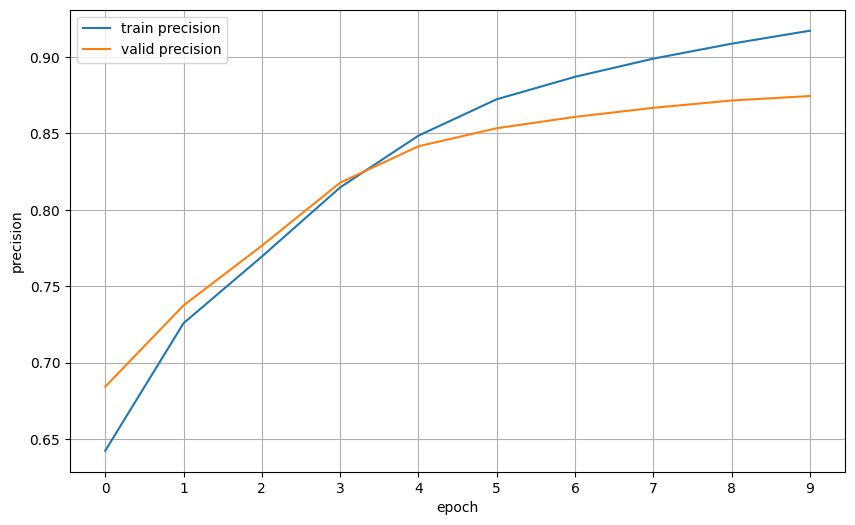

In [63]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics['train_precision'], label="train precision")
ax.plot(metrics['valid_precision'], label="valid precision")
ax.set_xlabel("epoch")
ax.set_ylabel("precision")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

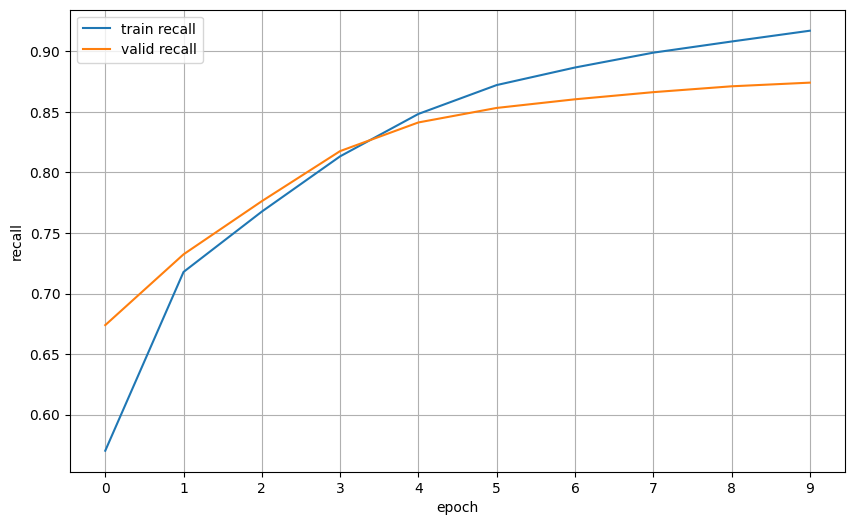

In [64]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics['train_recall'], label="train recall")
ax.plot(metrics['valid_recall'], label="valid recall")
ax.set_xlabel("epoch")
ax.set_ylabel("recall")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

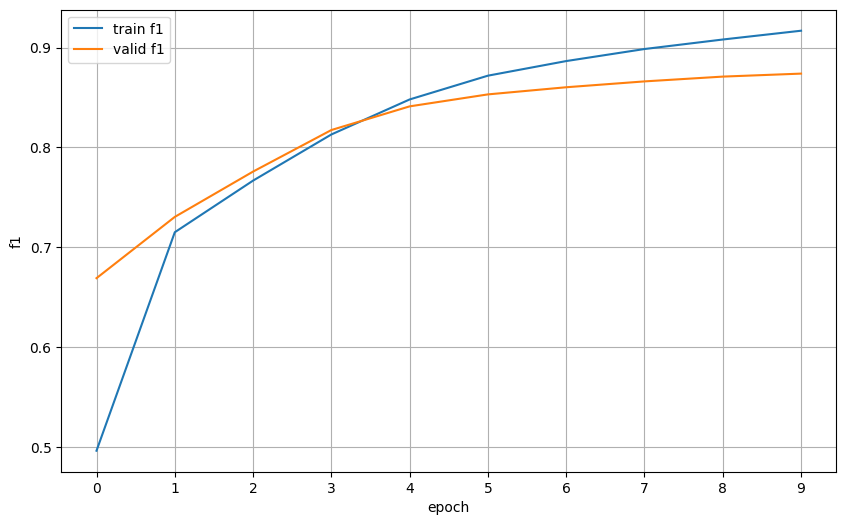

In [65]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics['train_f1'], label="train f1")
ax.plot(metrics['valid_f1'], label="valid f1")
ax.set_xlabel("epoch")
ax.set_ylabel("f1")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [66]:
model.load_state_dict(torch.load("nbow.pt"))

test_metrics = evaluate(test_data_loader, model, criterion, device)
test_loss = test_metrics['loss']
test_acc = test_metrics['accuracy']
test_precision = test_metrics['precision']
test_recall = test_metrics['recall']
test_f1 = test_metrics['f1']

evaluating...:   0%|          | 0/49 [00:00<?, ?it/s]D:\pythonworkspca\pytorch-sentiment-analysis\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\pythonworkspca\pytorch-sentiment-analysis\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
evaluating...:   4%|▍         | 2/49 [00:00<00:03, 11.94it/s]D:\pythonworkspca\pytorch-sentiment-analysis\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use 

In [67]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")
print(f"test_precision: {test_precision:.3f}, test_recall: {test_recall:.3f}, test_f1: {test_f1:.3f}")

test_loss: 0.352, test_acc: 0.858
test_precision: 0.508, test_recall: 0.438, test_f1: 0.470


In [ ]:
def predict_sentiment(text, model, tokenizer, vocab, device):
    tokens = tokenizer(text)
    ids = vocab.lookup_indices(tokens)
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [ ]:
text = "This film is terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

In [ ]:
text = "This film is great!"

predict_sentiment(text, model, tokenizer, vocab, device)

In [ ]:
text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, vocab, device)

In [ ]:
text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)